In [1]:
import numpy as np
import pandas as pd
import math

import statsmodels
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as stat
import statsmodels.tsa.stattools as ts

import matplotlib.pyplot as plt
from datetime import datetime, date

import seaborn as sb
import scipy.stats as stats

## Import Data

In [2]:
# Import Data
assets = ['BTCUSDT', 'ETHUSDT', 'LUNAUSDT', 'SOLUSDT', 'BTCBUSD', 'FTMUSDT', 'GALAUSDT', 'NEARUSDT', 'AVAXUSDT', '1000SHIBUSDT', 'SANDUSDT', 'WAVESUSDT', 'ETHBUSD', 'ADAUSDT', 'XRPUSDT', 'RUNEUSDT', 'BNBUSDT', 'ATOMUSDT', 'MATICUSDT', 'DOTUSDT', 'MANAUSDT', 'LINKUSDT', 'KNCUSDT', 'AXSUSDT', 'DOGEUSDT', 'LTCUSDT', 'CRVUSDT', 'FILUSDT', 'ONEUSDT']
data = {}
prices = {}

for asset in assets:
    data[asset] = pd.read_csv('./{}_1h.csv'.format(asset), index_col=0)
    data[asset].iloc[:,0] = pd.to_datetime(data[asset].iloc[:,0], unit='ms')
    prices[asset] = pd.DataFrame({'date': data[asset].iloc[:,0], 'price': data[asset].iloc[:,3]})
    prices[asset]['price'] = prices[asset]['price'].apply(lambda x: math.log(x))



In [3]:
prices['BTCUSDT']

,date,price
0,2020-01-01 05:00:00,8.883759
1,2020-01-01 06:00:00,8.884278
2,2020-01-01 07:00:00,8.880936
3,2020-01-01 08:00:00,8.878219
4,2020-01-01 09:00:00,8.879439
...,...,...
956,2022-03-01 01:00:00,10.673945
957,2022-03-01 02:00:00,10.667885
958,2022-03-01 03:00:00,10.665461
959,2022-03-01 04:00:00,10.670401


## Rolling Cointegration Engle-Granger

In [4]:
# Functions
def engle_granger_coint(A, B):
    result = stat.OLS(A, B).fit()
    a = ts.adfuller(result.resid)
    pvalue = a[1]
    return pvalue


In [15]:
##
# asset_A: string,
# asset_B: string,
# prices: object containing all imported data
# lookback_window: int that represents the max we are willing to lookback
# rolling_lookback: int that represents the length of the rolling window
def rolling_coint_consecutive_candles(asset_A, asset_B, prices, lookback_window, rolling_lookback):
    
    data_A = prices[asset_A][(len(prices[asset_A])-lookback_window):]
    data_B = prices[asset_B][(len(prices[asset_B])-lookback_window):]

    # make data same size
    length_A = len(data_A)
    length_B = len(data_B)
    if length_A > length_B:
        data_A = data_A[(length_A-length_B):]
    elif length_B > length_A:
        data_B = data_B[(length_B-length_A):]

    rolling_pvalues = pd.DataFrame({'date':[], 'pvalue': []})
    cointegrated = False
    saveDate = True
    consecutive_candles_cointegrated = 0
    start_date = ''

    _consecutive_candles_df = pd.DataFrame({'start_date': [], 'nbr_of_candles': []})

    for i in range(0, len(data_A)):
        if i+rolling_lookback <= len(data_A):
            data_1 = list(data_A['price'].iloc[i:i+rolling_lookback])
            data_2 = list(data_B['price'].iloc[i:i+rolling_lookback])
            pvalue = engle_granger_coint(data_1, data_2)
            rolling_pvalues = pd.concat([rolling_pvalues, pd.DataFrame({'date': [data_A['date'].iloc[i]], 'pvalue': [pvalue]})])
            if pvalue <= 0.05 and not cointegrated:
                cointegrated = True
            elif pvalue <= 0.05 and cointegrated:
                consecutive_candles_cointegrated += 1
                if saveDate and consecutive_candles_cointegrated > 3:
                    start_date = data_A['date'].iloc[i-3]
                    saveDate = False
            else:
                if consecutive_candles_cointegrated and not saveDate > 0:
                    _consecutive_candles_df = pd.concat([_consecutive_candles_df, pd.DataFrame({'start_date': [start_date], 'nbr_of_candles': [consecutive_candles_cointegrated]})])

                # reset variables
                cointegrated = False
                consecutive_candles_cointegrated = 0
                saveDate = True
                start_date = ''
    
    return _consecutive_candles_df

In [16]:
asset_A = 'SANDUSDT'
asset_B = 'AXSUSDT'

# nbr of datapoints
max_lookback = 2160

# nbr of candles to use in the cointegration calculation
rolling_lookback = 24*10
consecutive_candles_df = rolling_coint_consecutive_candles(asset_A, asset_B, prices, max_lookback, rolling_lookback)

## Get statistics of results

In [17]:
# Calculate max, min, mean and median of the consecutive periods cointegrated for each pair
print('max: {}, min: {}, mean: {}, median: {}'.format(consecutive_candles_df['nbr_of_candles'].max(), consecutive_candles_df['nbr_of_candles'].min(), consecutive_candles_df['nbr_of_candles'].mean(), consecutive_candles_df['nbr_of_candles'].median()))
consecutive_candles_df

max: 53.0, min: 24.0, mean: 38.5, median: 38.5


,start_date,nbr_of_candles
0,2021-12-02 01:00:00,53.0
0,2021-12-22 17:00:00,24.0


## Z-Score

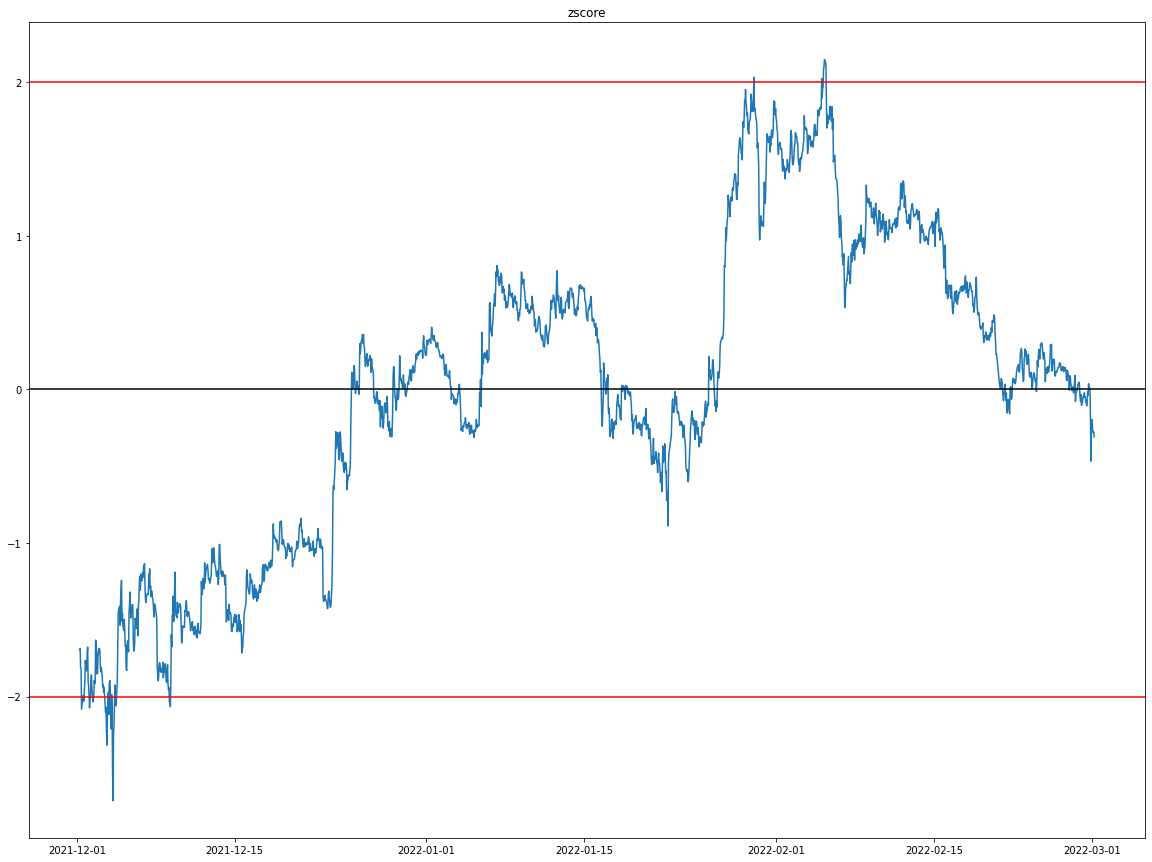

In [14]:
spread = data_A['price'] - data_B['price']
zscore = stats.zscore(spread)
df = pd.DataFrame({'x': data_A['date'], 'y':zscore})
std = df['y'].std()

plt.figure(figsize=(20,15))
plt.title('zscore')
plt.plot(df['x'],df['y'])
plt.axhline(y=0, color='black', linestyle='-')
plt.axhline(y=std*2, color='r', linestyle='-')
plt.axhline(y=-std*2, color='r', linestyle='-')